# Image Classification using CNN

<pre>
Consider a medical image dataset. 
Use CNN to perform classification over the dataset selected. 
Evaluate the performance of classifier in terms of accuracy of classification.
</pre>

# Kaggle Dataset

## Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Get key

In [ ]:
!mkdir /root/.kaggle/
!cp /drive/MyDrive/kaggle.json /root/.kaggle/

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 7.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=32dd3472f76bda4508e63795271486a437c995f8c1a882a0dc6f790e0e438d5d
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


## Download medical image dataset

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [04:03<00:00, 61.8MB/s]
100% 9.51G/9.51G [04:03<00:00, 41.9MB/s]


In [ ]:
!unzip -qq aptos2019-blindness-detection.zip

# Imports

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Getting Dataset ready for direct usage

In [ ]:
train = pd.read_csv("train.csv")
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [ ]:
test = pd.read_csv("test.csv")
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


 Test data is not labelled, so I'll split the data in train for the sake of testing

In [ ]:
train['diagnosis'].unique()

array([2, 4, 1, 0, 3])

1. Read the file names from csv
2. Load the image
3. Convert to grayscale
4. Flatten the data to fit into a dataset
5. Train SVC on it


In [ ]:
train_dir = "train"
test_dir = "test"

In [ ]:
def load_data(dir, files, labels, allowed) :

  count = 0
  x = []
  y = []
  l = len(files)
  for i in range(l):
    if labels[i] not in allowed : 
      continue
    pth = os.path.join(dir, str(files[i])+".png")
    img = cv2.imread(pth)
    img = cv2.resize(img, (200, 150))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x.append(img)
    y.append(labels[i])
    count += 1

    if count%100==0 : 
      print(f"{count} images reading complete")

  return x, y
  
datax, datay = load_data("train_images", train["id_code"], train["diagnosis"], [0, 1, 2, 3, 4])

100 images reading complete
200 images reading complete
300 images reading complete
400 images reading complete
500 images reading complete
600 images reading complete
700 images reading complete
800 images reading complete
900 images reading complete
1000 images reading complete
1100 images reading complete
1200 images reading complete
1300 images reading complete
1400 images reading complete
1500 images reading complete
1600 images reading complete
1700 images reading complete
1800 images reading complete
1900 images reading complete
2000 images reading complete
2100 images reading complete
2200 images reading complete
2300 images reading complete
2400 images reading complete
2500 images reading complete
2600 images reading complete
2700 images reading complete
2800 images reading complete
2900 images reading complete
3000 images reading complete
3100 images reading complete
3200 images reading complete
3300 images reading complete
3400 images reading complete
3500 images reading com

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(datax), np.array(datay), test_size=0.10)

In [ ]:
# A simple scaling
x_train = x_train/255
x_test = x_test/255

In [ ]:
SHAPE = x_train.shape
x_train = x_train.reshape(*SHAPE, 1)

(3295, 150, 200, 1)

In [ ]:
SHAPE_T = x_test.shape
x_test = x_test.reshape(*SHAPE_T, 1)

In [ ]:
o = OneHotEncoder()
y_train = o.fit_transform(y_train.reshape(-1, 1)).todense()
N_CLASSES = len(o.categories_[0])

In [ ]:
y_test = o.transform(y_test.reshape(-1, 1)).todense()

# Model

In [ ]:
def get_cnn(shape, channels, classes) : 
  cnn = Sequential()
  cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(shape[1], shape[2], channels)))
  cnn.add(MaxPooling2D(pool_size = (2, 2)))
  cnn.add(BatchNormalization())
  cnn.add(Conv2D(32, (3, 3), activation="relu"))
  cnn.add(MaxPooling2D(pool_size = (2, 2)))
  cnn.add(BatchNormalization())
  cnn.add(Conv2D(32, (3, 3), activation="relu"))
  cnn.add(MaxPooling2D(pool_size = (2, 2)))
  cnn.add(BatchNormalization())
  cnn.add(Flatten())
  cnn.add(Dense(activation = 'relu', units = 128))
  cnn.add(Dense(activation = 'relu', units = 64))
  cnn.add(Dense(activation = 'relu', units = 16))
  cnn.add(Dense(activation = 'softmax', units = classes))
  cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  return cnn

In [ ]:
classifier = get_cnn(SHAPE, 1, N_CLASSES)
classifier.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 148, 198, 32)      320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 99, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 74, 99, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_30 (Conv2D)          (None, 72, 97, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 48, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
history = classifier.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
103/103 [==============================] - 4s 28ms/step - loss: 0.3223 - accuracy: 0.6692 - val_loss: 0.4612 - val_accuracy: 0.2698
Epoch 2/50
103/103 [==============================] - 3s 25ms/step - loss: 0.2673 - accuracy: 0.7135 - val_loss: 0.4525 - val_accuracy: 0.2725
Epoch 3/50
103/103 [==============================] - 3s 25ms/step - loss: 0.2479 - accuracy: 0.7305 - val_loss: 0.4278 - val_accuracy: 0.5014
Epoch 4/50
103/103 [==============================] - 3s 25ms/step - loss: 0.2336 - accuracy: 0.7475 - val_loss: 0.3931 - val_accuracy: 0.5504
Epoch 5/50
103/103 [==============================] - 3s 26ms/step - loss: 0.2167 - accuracy: 0.7706 - val_loss: 0.3058 - val_accuracy: 0.6839
Epoch 6/50
103/103 [==============================] - 3s 25ms/step - loss: 0.2007 - accuracy: 0.7873 - val_loss: 0.2879 - val_accuracy: 0.6757
Epoch 7/50
103/103 [==============================] - 3s 25ms/step - loss: 0.1775 - accuracy: 0.8134 - val_loss: 0.2969 - val_accuracy: 0.7248

# Plot

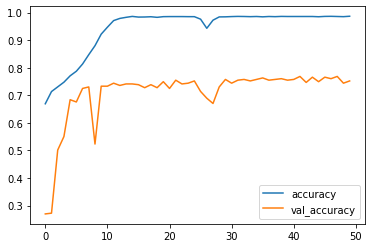

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Comparison

In [ ]:
res = classifier.predict(x_test)
res_arr_pred = []
for i in res :
  res_arr_pred.append(np.argmax(i))

res_arr_gt = []
for i in y_test:
  res_arr_gt.append(np.argmax(i))

In [ ]:
confusion_matrix(res_arr_gt, res_arr_pred)

array([[175,   0,   4,   0,   0],
       [  7,  14,  16,   0,   1],
       [  8,  12,  74,   4,   1],
       [  1,   2,   9,   6,   2],
       [  3,   4,  14,   3,   7]])